# Proyecto Final
- Situación actual:
La compañía Intercoonect está experimentando una disminución en el número de usuarios. El equipo de marketing se encuentra investigando las razones detrás de esta situación y dispone de una gran cantidad de información relevante, como contratos, datos personales de los clientes, información sobre el servicio de internet y detalles del servicio telefónico.

- Requerimiento:
Se necesita desarrollar un modelo predictivo que permita identificar a los clientes que podrían darse de baja. Esto facilitará la implementación de estrategias preventivas, como el ofrecimiento de códigos promocionales y opciones de planes especiales, con el objetivo de retener a los clientes y mejorar su experiencia con la compañía.


## Caracteristicas
Característica objetivo: la columna `'EndDate'` es igual a `'No'`.

Métrica principal: AUC-ROC.

Métrica adicional: exactitud.

Criterios de evaluación:

- AUC-ROC < 0.75 — 0 SP
- 0.75 ≤ AUC-ROC < 0.81 — 4 SP
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 SP
- 0.85 ≤ AUC-ROC < 0.87 — 5 SP
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 SP
- AUC-ROC ≥ 0.88 — 6 SP

Teniendo en cuenta la situación actual, sabemos cuál es nuestro objetivo, el cual está en el dataset Contract, específicamente en la columna DataEnd. Por lo tanto, trabajaremos en base a este dataset, que será nuestra principal fuente de información, ya que contiene nuestro valor objetivo (target) y mucha información relevante para el entrenamiento del modelo o de los diferentes modelos que se desarrollen.

Contamos con otros tres datasets denominados Internet, Phone y Personal. Es importante destacar que los dataframes de Internet y Phone incluyen a todos los usuarios presentes en el dataframe Contract, lo que significa que algunos clientes tal vez solo contrataron un único servicio, ya sea telefonía o internet. Por otro lado, el dataset Personal se encuentra completo.

La información contenida en el dataset Internet puede ser útil para entrenar el modelo, ya que dependiendo de los servicios contratados, el aumento en el precio podría notarse en los datos. De manera similar, en el caso del servicio de telefonía, podría observarse si el cliente cuenta con múltiples líneas.

En cuanto al dataset Personal, decidí no desarrollarlo tanto debido a que no quiero que mi dataset se sesgue en función del género del usuario (hombre o mujer). Aunque podría usar otras variables contenidas en este dataset, no cambiarían significativamente el resultado final.

### El plan de trabajo

- Verificación inicial:

    - Asegurarnos de que todos los datasets estén en el formato correspondiente.
    - Realizar una revisión para detectar duplicados.
    - Examinar una descripción general de los datasets.
- Preparación de datos:

    - Cambiar las columnas al formato adecuado, como fechas, floats o integers.
    - Agregar nuevas columnas para separar el mes, día y año a partir de la fecha BeginDate en el primer dataset.
- Visualización de datos:

    - Graficar los datasets para identificar posibles tendencias antes de crear los modelos. Esto nos permitirá verificar qué valores pueden aportar más al desempeño del modelo.
- Transformaciones necesarias:

    - Convertir las columnas de tipo object a One-Hot Encoding, ya que este método es más eficiente que otros tipos de codificación. Aunque el número de columnas aumentará, no será un incremento tan elevado como para afectar negativamente el entrenamiento del modelo.
- Estructuración del código:

    - Implementar funciones que permitan trabajar con diferentes modelos de manera eficiente, evitando repetir código innecesariamente.

## Importacion de librerias

In [1]:
try:
    from lazypredict.Supervised import LazyClassifier
except ModuleNotFoundError:
    !pip install lazypredict
    !pip install ydata-profiling

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lazypredict.Supervised import LazyClassifier

import statsmodels.api as sm

from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import roc_auc_score

from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

## Carga de los datos

In [3]:
path = '/Users/gerardomacedo/Documents/TripleTen/Proyecto Final/final_provider'
contract_df = pd.read_csv(path+'/contract.csv')
internet_df = pd.read_csv(path+'/internet.csv')
personal_df = pd.read_csv(path+'/personal.csv')
phone_df = pd.read_csv(path+'/phone.csv')

In [4]:
def check_df(df):

    display(df.sample(5,random_state=12345))
    display(df.info())
    display(df[df.duplicated()])
    display(df.describe())
    df = df.set_index('customerID')
    return df

### contract_df

#### Revision de Info

In [5]:
contract_df = check_df(contract_df)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1128,0098-BOWSO,2017-11-01,No,Month-to-month,Yes,Electronic check,19.40,529.8
2875,9992-RRAMN,2018-02-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,85.10,1873.7
1783,8380-PEFPE,2019-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,71.65,71.65
3804,9773-PEQBZ,2019-04-01,No,Month-to-month,No,Electronic check,79.85,797.25
6087,8319-QBEHW,2017-12-01,No,One year,Yes,Bank transfer (automatic),39.95,1023.75


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


,MonthlyCharges
count,7043.00
mean,64.76
std,30.09
min,18.25
25%,35.50
50%,70.35
75%,89.85
max,118.75


#### Desarrollo de Base de Datos

In [6]:
contract_df['End'] = (contract_df['EndDate'] == 'No').astype(int)
contract_df.sample(5, random_state=12345)


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,End
customerID,,,,,,,,
0098-BOWSO,2017-11-01,No,Month-to-month,Yes,Electronic check,19.40,529.8,1
9992-RRAMN,2018-02-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,85.10,1873.7,0
8380-PEFPE,2019-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,71.65,71.65,0
9773-PEQBZ,2019-04-01,No,Month-to-month,No,Electronic check,79.85,797.25,1
8319-QBEHW,2017-12-01,No,One year,Yes,Bank transfer (automatic),39.95,1023.75,1


In [7]:
contract_df_end = contract_df.groupby('Type')['End'].value_counts()
contract_df_end

Type            End
Month-to-month  1      2220
                0      1655
One year        1      1307
                0       166
Two year        1      1647
                0        48
Name: count, dtype: int64

In [8]:
contract_df['EndDate'] = contract_df['EndDate'].replace('No',None)
contract_df['TotalCharges'] = contract_df['TotalCharges'].replace(' ',None)
contract_df['TotalCharges'] = contract_df['TotalCharges'].astype('float')
contract_df['EndDate'] = pd.to_datetime(contract_df['EndDate'])
contract_df['BeginDate'] = pd.to_datetime(contract_df['BeginDate'])

In [9]:
mod_contract = contract_df.copy()

In [10]:
def longevity_df(df):
    today = datetime.now()
    EndDate = df['EndDate'].fillna(today)
    longevity = (EndDate - df['BeginDate']).dt.days
    return longevity

In [11]:
def time_before_renew(df):
    today = datetime.now()
    renew = []
    new_date = today
    for index, row in df.iterrows():
        if row['End']==0:
            if row['Type'] == 'Month-to-month':
                if row['EndDate'].day <= row['BeginDate'].day:
                    new_date = datetime(row['EndDate'].year,row['EndDate'].month,row['BeginDate'].day)
                    renew.append((new_date-row['EndDate']).days)
                else:
                    new_date = datetime(row['EndDate'].year,row['EndDate'].month,row['BeginDate'].day)
                    new_date = new_date + timedelta(days = 30)
                    renew.append((new_date-row['EndDate']).days)
            elif row['Type'] == 'One year':
                if row['EndDate'].day <= row['BeginDate'].day and row['EndDate'].month <= row['BeginDate'].month:
                    new_date = datetime(row['EndDate'].year,row['BeginDate'].month,row['BeginDate'].day)
                    renew.append((new_date-row['EndDate']).days)
                else:
                    new_date = datetime(row['EndDate'].year,row['BeginDate'].month,row['BeginDate'].day)
                    new_date = new_date + timedelta(days = 365)
                    renew.append((new_date-row['EndDate']).days)
            elif row['Type'] == 'Two year':
                if row['EndDate'].day <= row['BeginDate'].day and row['EndDate'].month <= row['BeginDate'].month and row['EndDate'].year-row['BeginDate'].year % 2 == 0:
                        new_date = datetime(row['EndDate'].year,row['BeginDate'].month,row['BeginDate'].day)
                        renew.append((new_date-row['EndDate']).days)
                else:
                    new_date = datetime(row['EndDate'].year,row['BeginDate'].month,row['BeginDate'].day)
                    new_date = new_date + timedelta(days = 730)
                    renew.append((new_date-row['EndDate']).days)
                

        else:
            renew.append(None)

    return renew


        

In [12]:
mod_contract['EndWeek'] = mod_contract['EndDate'].dt.dayofweek
mod_contract['EndMonth'] = mod_contract['EndDate'].dt.month
mod_contract['BeginYear'] = mod_contract['BeginDate'].dt.year
mod_contract['BeginMonth'] = mod_contract['BeginDate'].dt.month
mod_contract['BeginWeek'] = mod_contract['BeginDate'].dt.dayofweek

In [13]:
mod_contract['Longevity'] = longevity_df(mod_contract)
mod_contract['CanceledBeforeRenew'] = time_before_renew(mod_contract)

#### Grafica

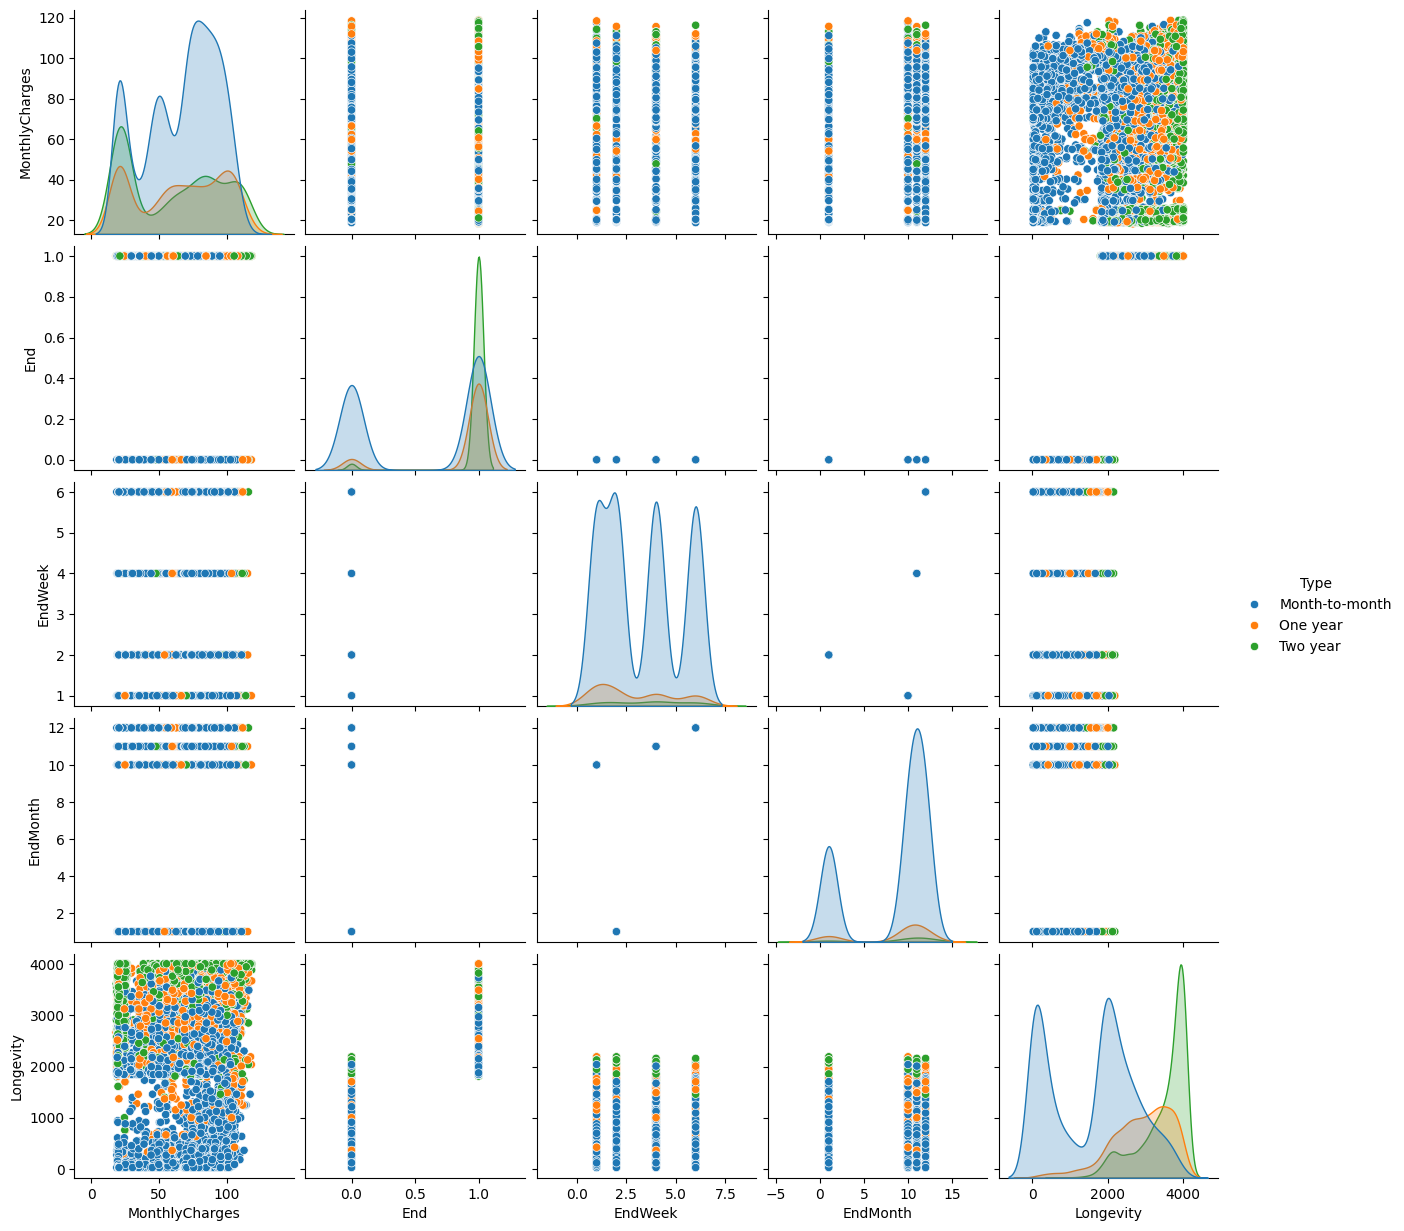

In [14]:
graphic = mod_contract.drop(['TotalCharges','BeginYear','BeginMonth','BeginWeek','CanceledBeforeRenew'], axis=1)
sns.pairplot(graphic, hue="Type")

- Esta gráfica presenta información clave. Se observa que la tasa de cancelación entre los usuarios con contratos mes a mes es significativamente más alta en comparación con los usuarios de otros tipos de contrato.

- Otro aspecto relevante es que los usuarios con contratos mes a mes tienden a realizar pagos más elevados, lo que sugiere que están contratando más servicios en comparación con los usuarios de contratos a más largo plazo.

- Los usuarios con mayor longevidad pertenecen al grupo con contratos de uno a dos años, lo que indica una mayor estabilidad en este segmento.

- Además, se puede identificar que hay tres días específicos, así como ciertos meses particulares, en los que los usuarios tienden a cancelar su servicio.

In [15]:
def encoder_object (df):
    
    df_categories = df.select_dtypes('object')
    df_data = df.drop(df_categories.columns, axis=1)
    df_categories = pd.get_dummies(df_categories, drop_first=True)
    df = df_data.merge(df_categories, on='customerID', how='inner')
    return df


In [16]:
contract_encode = encoder_object(contract_df)

contract_encode['BeginYear'] = contract_encode['BeginDate'].dt.year
contract_encode['BeginMonth'] = contract_encode['BeginDate'].dt.month
contract_encode['BeginWeek'] = contract_encode['BeginDate'].dt.dayofweek
contract_encode = contract_encode.drop(['EndDate','BeginDate'], axis=1)
display(contract_encode)

,MonthlyCharges,TotalCharges,End,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,BeginYear,BeginMonth,BeginWeek
customerID,,,,,,,,,,,,
7590-VHVEG,29.85,29.85,1,False,False,True,False,True,False,2020,1,2
5575-GNVDE,56.95,1889.50,1,True,False,False,False,False,True,2017,4,5
3668-QPYBK,53.85,108.15,0,False,False,True,False,False,True,2019,10,1
7795-CFOCW,42.30,1840.75,1,True,False,False,False,False,False,2016,5,6
9237-HQITU,70.70,151.65,0,False,False,True,False,True,False,2019,9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,84.80,1990.50,1,True,False,True,False,False,True,2018,2,3
2234-XADUH,103.20,7362.90,1,True,False,True,True,False,False,2014,2,5
4801-JZAZL,29.60,346.45,1,False,False,True,False,True,False,2019,3,4


#### Prueba de modelo

He eliminado los valores de 'EndDate' porque no aportan valor al modelo, dado que esos usuarios ya han dejado de ser parte del sistema. Mi objetivo es analizar las razones previas a su cancelación, antes de que se dieran de baja."

In [18]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_ones] + [features_zeros] * repeat)
    target_upsampled = pd.concat([target_ones] + [target_zeros] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled

In [19]:
def split_df(df):
    features = df.drop('End', axis=1)
    target = df.End
    features,target=upsample(features,target,2)
    features_train, features_valid, target_train, target_valid = train_test_split(features,target,test_size=0.2,random_state=12345)
    return features_train, features_valid, target_train, target_valid

In [20]:
def model_test(df):
    features_train, features_valid, target_train, target_valid =split_df(df)

    clf = LazyClassifier()
    models, results = clf.fit(features_train, features_valid, target_train, target_valid)
    display(results)

In [21]:
def random_forest_model(df):
    
    features_train, features_valid, target_train, target_valid =split_df(df)

    model = RandomForestClassifier(max_depth=20, n_estimators=500)
    model.fit(features_train,target_train)
    prediction = model.predict(features_valid)

    roc = roc_auc_score(target_valid,prediction)
    print('El resultado del valor AUC ROC para el modelo de Random Forest es de: ',roc)


In [22]:
def lgb_model(df):
    features_train, features_valid, target_train, target_valid =split_df(df)

    params={
    'objective': 'binary',  
    'metric': 'binary_error',  
    'boosting_type': 'gbdt', 
    'num_leaves': 31, 
    'learning_rate': 0.05, 
    'feature_fraction': 0.9 

    }
    train_data = lgb.Dataset(features_train, label=target_train)
    test_data = lgb.Dataset(features_valid, label=target_valid, reference=train_data)

    model_lgb = lgb.train(params,
                        train_data,
                        valid_sets=[test_data],
                        num_boost_round=100)
    prediction = model_lgb.predict(features_valid)
    roc = roc_auc_score(target_valid,prediction)
    print('El resultado para el modelo de gradiente exponencial es: ',roc)
    

In [23]:
features = mod_contract.drop('End', axis=1)
target = mod_contract.End
features_up, target_up = upsample(features, target, 2)

In [24]:
target_up.mean()


0.5805655296229802

In [25]:
model_test(contract_encode)
lgb_model(contract_encode)
random_forest_model(contract_encode)

100%|██████████| 29/29 [00:04<00:00,  6.21it/s]

[LightGBM] [Info] Number of positive: 4129, number of negative: 3000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 7129, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.579184 -> initscore=0.319423
[LightGBM] [Info] Start training from score 0.319423


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.94,0.94,0.94,0.94,0.27
RandomForestClassifier,0.93,0.94,0.94,0.93,0.43
BaggingClassifier,0.91,0.92,0.92,0.91,0.09
DecisionTreeClassifier,0.91,0.91,0.91,0.91,0.02
ExtraTreeClassifier,0.90,0.91,0.91,0.90,0.01
XGBClassifier,0.90,0.89,0.89,0.90,0.07
LGBMClassifier,0.88,0.87,0.87,0.88,0.12
NuSVC,0.86,0.84,0.84,0.86,0.84
KNeighborsClassifier,0.83,0.82,0.82,0.83,0.03


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4129, number of negative: 3000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 7129, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.579184 -> initscore=0.319423
[LightGBM] [Info] Start training from score 0.319423
El resultado para el modelo de gradiente exponencial es:  0.932151424385057
El resultado del valor AUC ROC para el modelo de Random Forest es de:  0.9368537752363169


#### Conclusion

No utilicé la base de datos mod_contract, con la cual realicé la gráfica, ya que contiene valores adicionales creados por mí y son mas para realizar una revision en las graficas. Aunque estos valores aportan información valiosa, como la longevidad de los usuarios o el tiempo con el que terminan su contrato anticipadamente, entre otros, decidí no incluirlos en este análisis para mantener la integridad de los datos originales.

Por lo tanto, trabajé exclusivamente con la tabla original. Únicamente realicé dos modificaciones:

- Convertí las columnas de tipo object a formato One-Hot Encoding.
- Cambié el formato de las columnas de fecha para adaptarlas al análisis.

### Internet_df

#### Desarrollo

In [29]:
internet_df=check_df(internet_df)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4878,7823-JSOAG,Fiber optic,No,No,No,No,No,No
5002,4450-YOOHP,DSL,No,No,Yes,No,Yes,Yes
4160,2498-XLDZR,DSL,Yes,Yes,Yes,Yes,No,Yes
683,7905-TVXTA,DSL,Yes,No,No,Yes,Yes,No
1930,9802-CAQUT,Fiber optic,Yes,Yes,Yes,No,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


#### Grafica

In [30]:
def ordinar_encoder(df):
    encoder = OrdinalEncoder()
    grafic_int = df
    grafic_int = pd.DataFrame(encoder.fit_transform(grafic_int), columns=grafic_int.columns, index=grafic_int.index)
    display(encoder.categories_)
    return grafic_int


In [31]:
grafic_int = ordinar_encoder(internet_df)

[array(['DSL', 'Fiber optic'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object)]

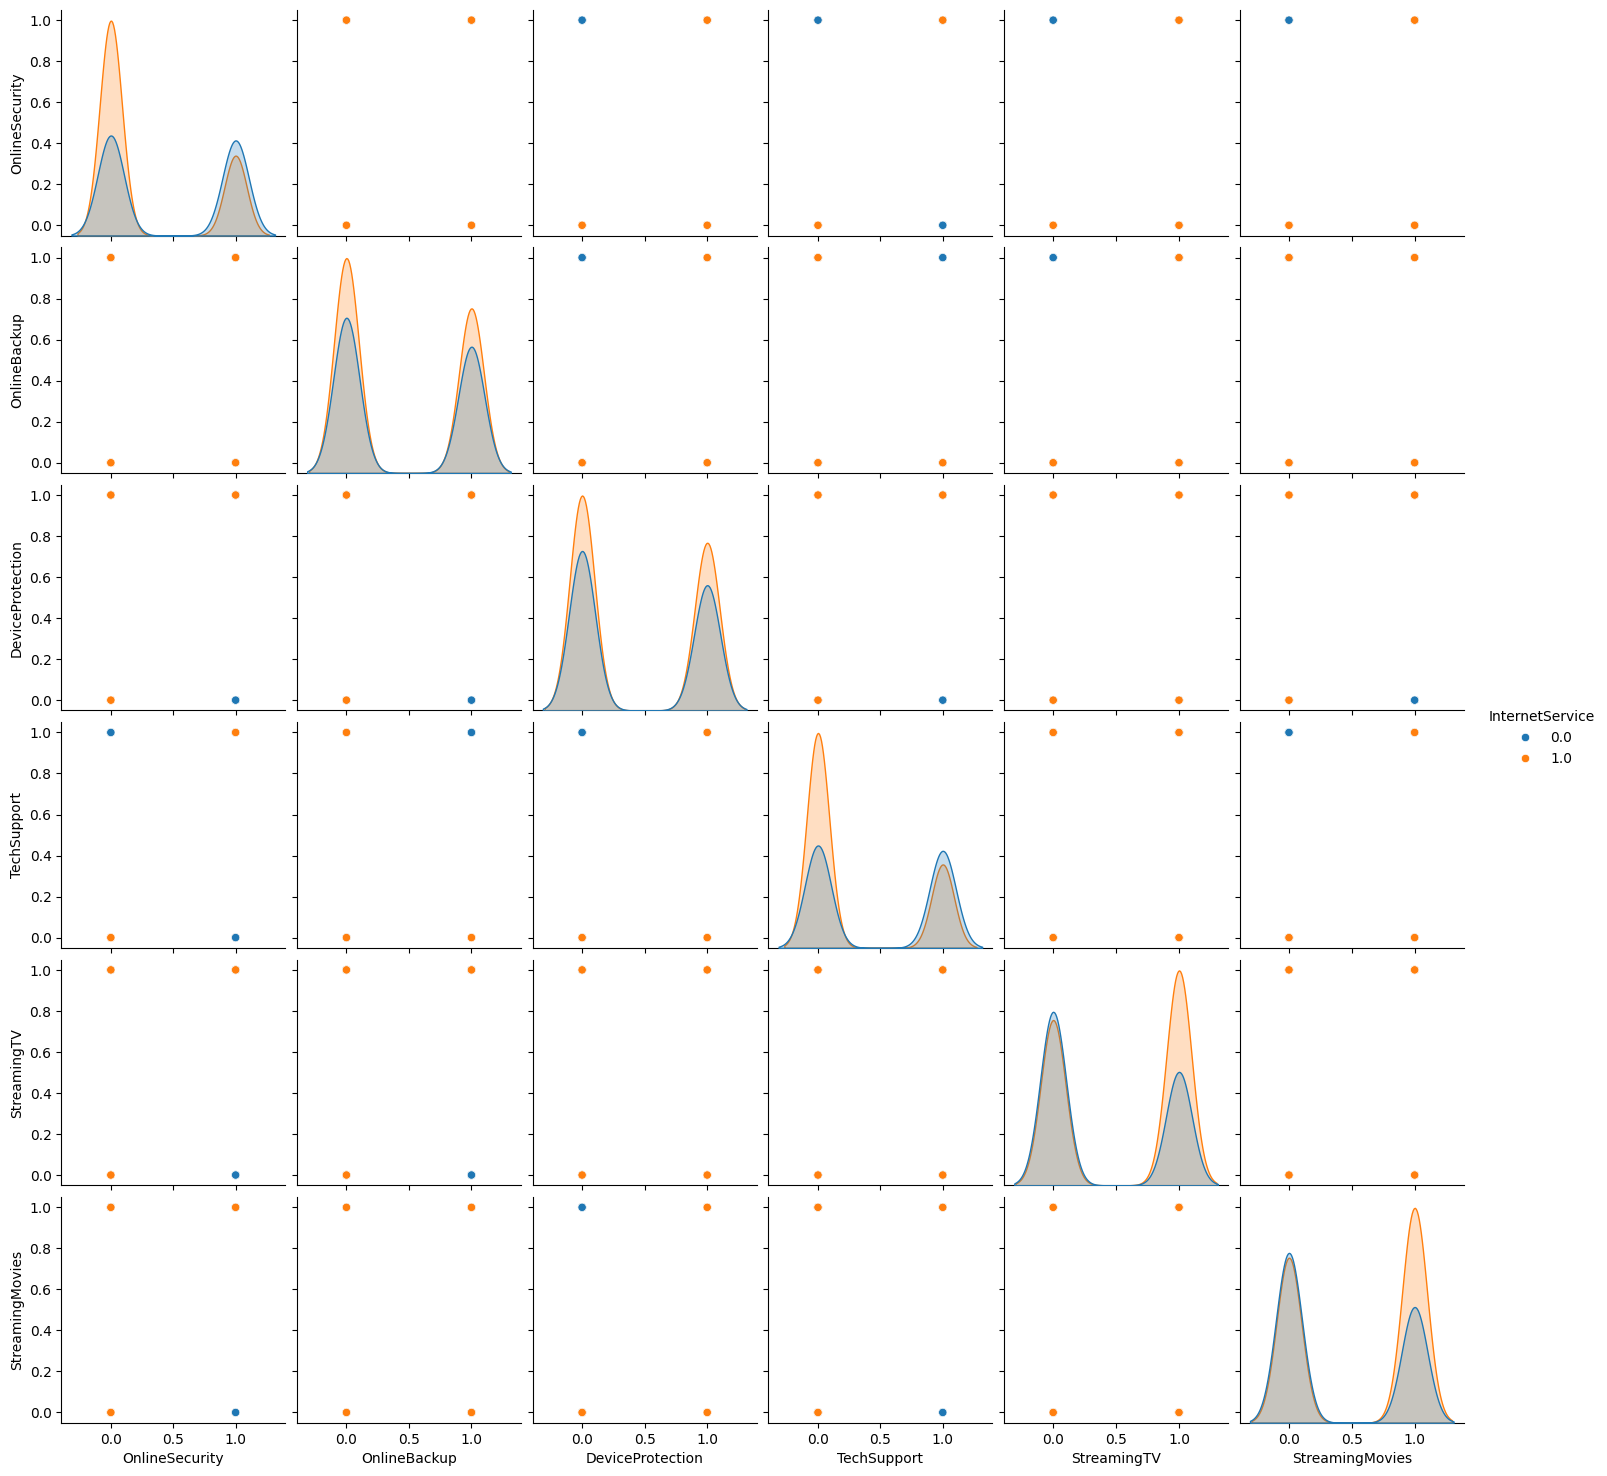

In [32]:
sns.pairplot(grafic_int, hue='InternetService')

Utilice ordinal encoder para poder graficar las tablas y buscar similitudes pero para cargar el modelo utilizare One-Hot

#### Modelo

In [33]:
data_model = contract_encode.merge(internet_df, on='customerID', how='left')

data_model.sample(3, random_state=21)

,MonthlyCharges,TotalCharges,End,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,BeginYear,BeginMonth,BeginWeek,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,,
3097-NQYSN,86.85,156.35,0,False,False,True,False,False,True,2019,9,6,Fiber optic,No,No,No,No,Yes,No
2499-AJYUA,110.80,7882.25,1,False,True,True,True,False,False,2014,2,5,Fiber optic,No,Yes,Yes,Yes,Yes,Yes
4625-EWPTF,30.45,226.45,0,False,False,True,False,True,False,2019,4,0,DSL,Yes,No,No,No,No,No


In [34]:
data_model = encoder_object(data_model)

In [35]:
model_test(data_model)
lgb_model(data_model)
random_forest_model(data_model)

100%|██████████| 29/29 [00:04<00:00,  6.07it/s]

[LightGBM] [Info] Number of positive: 4129, number of negative: 3000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 7129, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.579184 -> initscore=0.319423
[LightGBM] [Info] Start training from score 0.319423


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.94,0.94,0.94,0.94,0.27
RandomForestClassifier,0.93,0.94,0.94,0.93,0.44
BaggingClassifier,0.91,0.92,0.92,0.91,0.09
DecisionTreeClassifier,0.91,0.91,0.91,0.91,0.02
ExtraTreeClassifier,0.90,0.91,0.91,0.90,0.01
XGBClassifier,0.90,0.89,0.89,0.90,0.05
LGBMClassifier,0.88,0.87,0.87,0.88,0.07
NuSVC,0.86,0.84,0.84,0.86,0.84
KNeighborsClassifier,0.83,0.82,0.82,0.83,0.03


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4129, number of negative: 3000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 7129, number of used features: 18
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.579184 -> initscore=0.319423
[LightGBM] [Info] Start training from score 0.319423
El resultado para el modelo de gradiente exponencial es:  0.9302537570830253
El resultado del valor AUC ROC para el modelo de Random Forest es de:  0.9243370806913811


### Personal_df

#### Desarrollo

In [36]:
personal_df = check_df(personal_df)

,customerID,gender,SeniorCitizen,Partner,Dependents
1128,0098-BOWSO,Male,0,No,No
2875,9992-RRAMN,Male,0,Yes,No
1783,8380-PEFPE,Male,0,No,Yes
3804,9773-PEQBZ,Male,0,No,No
6087,8319-QBEHW,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents


,SeniorCitizen
count,7043.00
mean,0.16
std,0.37
min,0.00
25%,0.00
50%,0.00
75%,0.00
max,1.00


In [37]:
grafic_int = ordinar_encoder(personal_df)

[array(['Female', 'Male'], dtype=object),
 array([0, 1]),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object)]

#### Grafica

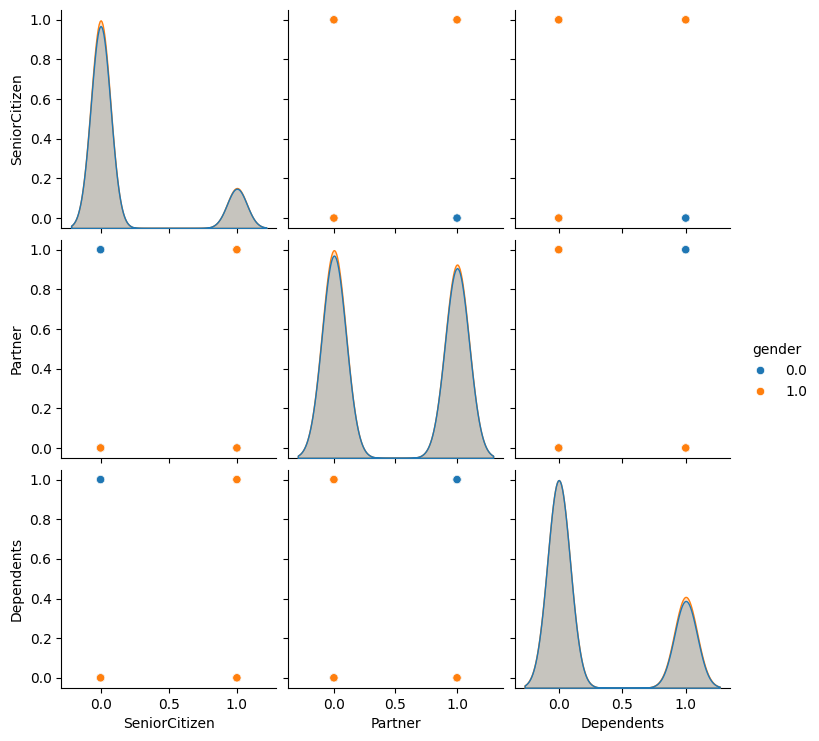

In [38]:
sns.pairplot(grafic_int, hue="gender")

In [39]:
data = contract_encode.merge(personal_df, on='customerID', how='left')
data = encoder_object(data)

In [40]:
model_test(data)
lgb_model(data)
random_forest_model(data)

100%|██████████| 29/29 [00:05<00:00,  5.42it/s]

[LightGBM] [Info] Number of positive: 4129, number of negative: 3000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 543
[LightGBM] [Info] Number of data points in the train set: 7129, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.579184 -> initscore=0.319423
[LightGBM] [Info] Start training from score 0.319423


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.94,0.94,0.94,0.94,0.36
RandomForestClassifier,0.93,0.93,0.93,0.93,0.56
BaggingClassifier,0.91,0.92,0.92,0.92,0.10
ExtraTreeClassifier,0.90,0.91,0.91,0.91,0.02
DecisionTreeClassifier,0.91,0.91,0.91,0.91,0.04
XGBClassifier,0.90,0.90,0.90,0.90,0.06
LGBMClassifier,0.88,0.87,0.87,0.88,0.07
NuSVC,0.85,0.83,0.83,0.85,0.91
KNeighborsClassifier,0.82,0.81,0.81,0.82,0.03


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4129, number of negative: 3000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 559
[LightGBM] [Info] Number of data points in the train set: 7129, number of used features: 15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.579184 -> initscore=0.319423
[LightGBM] [Info] Start training from score 0.319423
El resultado para el modelo de gradiente exponencial es:  0.9334947679620337
El resultado del valor AUC ROC para el modelo de Random Forest es de:  0.932310265686389


### Phone_df

In [41]:
phone_df = check_df(phone_df)

,customerID,MultipleLines
1649,8966-KZXXA,Yes
1920,7206-PQBBZ,No
2852,4567-AKPIA,Yes
911,7047-YXDMZ,No
6259,7619-PLRLP,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


In [42]:
data_model = data_model.merge(phone_df, on='customerID', how='outer')

In [43]:
data_model = encoder_object(data_model)

In [44]:
data_model

,MonthlyCharges,TotalCharges,End,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,BeginYear,BeginMonth,BeginWeek,InternetService_Fiber optic,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,65.60,593.30,1,True,False,True,False,False,True,2019,5,2,False,False,True,False,True,True,False,False
0003-MKNFE,59.90,542.40,1,False,False,False,False,False,True,2019,5,2,False,False,False,False,False,False,True,True
0004-TLHLJ,73.90,280.85,0,False,False,True,False,True,False,2019,9,6,True,False,False,True,False,False,False,False
0011-IGKFF,98.00,1237.85,0,False,False,True,False,True,False,2018,12,5,True,False,True,True,False,True,True,False
0013-EXCHZ,83.90,267.40,0,False,False,True,False,False,True,2019,9,6,True,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9987-LUTYD,55.15,742.90,1,True,False,False,False,False,True,2019,1,1,False,True,False,False,True,False,False,False
9992-RRAMN,85.10,1873.70,0,False,False,True,False,True,False,2018,2,3,True,False,False,False,False,False,True,True
9992-UJOEL,50.30,92.75,1,False,False,True,False,False,True,2019,12,6,False,False,True,False,False,False,False,False


In [45]:
model_test(data_model)
random_forest_model(data_model)
lgb_model(data_model)

100%|██████████| 29/29 [00:05<00:00,  5.73it/s]

[LightGBM] [Info] Number of positive: 4129, number of negative: 3000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 540
[LightGBM] [Info] Number of data points in the train set: 7129, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.579184 -> initscore=0.319423
[LightGBM] [Info] Start training from score 0.319423


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.94,0.94,0.94,0.94,0.28
RandomForestClassifier,0.93,0.93,0.93,0.93,0.45
DecisionTreeClassifier,0.91,0.92,0.92,0.91,0.02
BaggingClassifier,0.91,0.92,0.92,0.91,0.10
ExtraTreeClassifier,0.90,0.90,0.90,0.90,0.01
XGBClassifier,0.90,0.90,0.90,0.90,0.06
LGBMClassifier,0.88,0.86,0.86,0.87,0.08
NuSVC,0.84,0.83,0.83,0.84,0.94
KNeighborsClassifier,0.82,0.82,0.82,0.82,0.06


El resultado del valor AUC ROC para el modelo de Random Forest es de:  0.9189131364997861
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4129, number of negative: 3000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 567
[LightGBM] [Info] Number of data points in the train set: 7129, number of used features: 19
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.579184 -> initscore=0.319423
[LightGBM] [Info] Start training from score 0.319423
El resultado para el modelo de gradiente exponencial es:  0.9280656371157012


## Modelo con todo los datasets

In [46]:
all_df = contract_encode.merge(internet_df, on='customerID', how='left')
all_df = all_df.merge(personal_df, on='customerID', how='left')
all_df = all_df.merge(phone_df, on='customerID', how='left')


In [47]:
all_df = encoder_object(all_df)

In [48]:
model_test(all_df)
random_forest_model(all_df)
lgb_model(all_df)

100%|██████████| 29/29 [00:05<00:00,  5.17it/s]

[LightGBM] [Info] Number of positive: 4129, number of negative: 3000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 543
[LightGBM] [Info] Number of data points in the train set: 7129, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.579184 -> initscore=0.319423
[LightGBM] [Info] Start training from score 0.319423


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.94,0.94,0.94,0.94,0.36
RandomForestClassifier,0.93,0.93,0.93,0.93,0.51
BaggingClassifier,0.91,0.92,0.92,0.92,0.10
ExtraTreeClassifier,0.90,0.91,0.91,0.91,0.02
DecisionTreeClassifier,0.91,0.91,0.91,0.91,0.05
XGBClassifier,0.90,0.90,0.90,0.90,0.09
LGBMClassifier,0.88,0.87,0.87,0.88,0.13
NuSVC,0.85,0.83,0.83,0.85,0.91
KNeighborsClassifier,0.82,0.81,0.81,0.82,0.03


El resultado del valor AUC ROC para el modelo de Random Forest es de:  0.925133232193566
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4129, number of negative: 3000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 575
[LightGBM] [Info] Number of data points in the train set: 7129, number of used features: 23
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.579184 -> initscore=0.319423
[LightGBM] [Info] Start training from score 0.319423
El resultado para el modelo de gradiente exponencial es:  0.9319018166258218


## Conclusiones

La base de datos contract_df es más que suficiente para realizar un análisis sobre la probabilidad de que un cliente abandone el servicio, ya que proporciona una gran cantidad de información relevante sobre el perfil del cliente.

Actualmente, podemos observar que Random Forest es un modelo eficaz para esta tarea de predicción. Sin embargo, también vale la pena considerar el uso de LightGBM como una alternativa viable, ya que puede ofrecer buenos resultados con un menor tiempo de entrenamiento.

Aunque al agregar tablas adicionales se observa un incremento en la eficiencia del modelo, estos cambios no son lo suficientemente significativos como para justificar la incorporación de más columnas, ya que esto podría hacer que el modelo sea más pesado sin aportar un beneficio sustancial.